In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
import os

<class 'str'>


<AxesSubplot:xlabel='Date_int'>

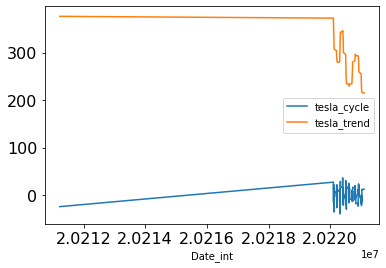

In [ ]:

def produceHP(ticker):
    ticker = "\\Data\\{}".format(ticker) + ".csv"
    dir = os.getcwd() + ticker
    data = pd.read_csv(ticker)
    data = data.set_index('Date')
    x = data.index
    x = [dt.datetime.strptime(d, '%Y-%m-%d') for d in x]
    price = data['Close']
    cycle, trend = sm.tsa.filters.hpfilter(price, 100000)
    y = trend
    plt.plot(x, y)
    y = price
    plt.plot(x, y)
    plt.show()

produceHP("TSLA")
produceHP("^TNX")
